In [57]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [58]:
dataset_name = "W16_comb"
df_list = [ "BES_Panel", ]

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [59]:
# Fix up all the datasets we'll be using (make sure all categories correctly/consistently ordered)
immig_var_stub = ["immigEcon","immigCultural","immigSelf","immigrationLevel","immigContributeTake",
                  "immigrantsWelfareState","controlImmig","effectsEUImmigration","euPriorityBalance",
                  "changeImmig","changeImmigLab","govtHandleImmig","labHandleImmig",
                  "asylumMore","euMore","noneuMore","studentsMore","familiesMore",
                  "responsibleImmig","achieveReduceImmig",
                  "conPriorities_immig","labPriorities_immig","ldPriorities_immig","ukipPriorities_immig",
                  "dealPriority","ukCoopMovement","negotiationSpecifics","benefitsToMigrants"]

fix_cat_dict = {}
# not sure about best way to line up "expectation" variables
fix_cat_dict['changeImmig']=['Getting a lot lower', 'Getting a little lower','Staying about the same',
                             'Getting a little higher', 'Getting a lot higher',  "Don't know" ]
fix_cat_dict['effectsEUImmigration'] = ['Much lower', 'Lower', 'About the same', 'Higher', 'Much higher', "Don't know"]
fix_cat_dict['controlImmig']=['No control at all', 'A little control', 'Some control', 'A lot of control', 'Complete control', "Don't know"]

# lets try to get every axis pointing in the same "sentiment" direction
fix_cat_dict['immigEcon']=['Bad for economy','2', '3', '4', '5', '6', 'Good for economy',  "Don't know"]
fix_cat_dict['immigCultural']=['Undermines cultural life', '2', '3', '4', '5', '6', 'Enriches cultural life', "Don't know" ]
fix_cat_dict["immig(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)W"] = ['Allow many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Allow many more', "Don't know"]
fix_cat_dict['(students|eu|asylum|families|noneu)More'] = ['Many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Many more', "Don't know"]
fix_cat_dict['immigrantsWelfareState'] = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "Don't know"]
fix_cat_dict['immigContributeTake'] = ['Get more than they pay', '2.0', '3.0', '4.0',
                                       '5.0', '6.0', 'Pay more than they get', "Don't know"]
fix_cat_dict['euPriorityBalance'] = ['Control immigration', '9', '8', '7', '6', '5', '4', '3', '2', '1', 'Access to the single market', "Don't know"]
fix_cat_dict['immigrationLevel'] = ['Decreased a lot', 'Decreased a little', 'Left the same as it is now',
                                    'Increased a little', 'Increased a lot',  "Don't know"]
fix_cat_dict['ukCoopMovement'] = ["Bad for Britain", "Neither good nor bad for Britain", "Good for Britain", "Don't know"]
fix_cat_dict['benefitsToMigrants'] = ['Immediately on arrival','After living in GB for a year',
                                      'After they have worked and paid taxes for at least four years',
                                      'After they become a British citizen', 'Never', "Don't know"]



# fix_cat_dict['immigrantsWelfareState'] = ['Strongly disagree', 'Disagree',  'Neither agree nor disagree','Agree', 'Strongly agree',"Don't know", ]
# mostly dealPrioritImmig, but might be worth setting alongside the other dealPriority variables
fix_cat_dict['dealPriority'] = ['Not important at all', 'Not very important', 'Somewhat important',
                                'Very important', 'Extremely important' , "Don't know"]

# fix_cat_dict['euPriorityBalance'] = ['Access to the single market', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Control immigration', "Don't know"]
fix_cat_dict['(lab|govt)HandleImmig'] = ['Very badly', 'Fairly badly', 'Neither well nor badly', 'Fairly well', 'Very well', "Don't know"]
fix_cat_dict['responsibleImmig(Conservatives|LibDems|Labour|ScottishGovt|WelshGovt|None|DontKnow)'] = ["No","Yes","Don't know"]
fix_cat_dict['achieveReduceImmig(Brexit|Con|Grn|LD|Lab|None|PC|SNP|TIG|UKIP)'] = ["No","Yes","Don't know"]

fix_cat_dict["(con|lab|ld|ukip)Priorities_immig"] = ["No","Yes","Don't know"]

# my time plotting function assumes variable names won't contain _ - quick hack to circumvent having to change that
BES_Panel[[x.replace("_1","ContinuePayingMoney").replace("_2","AcceptingFoM").replace("_3","AcceptingEUReg").replace("_none","Nothing") for x in search(BES_Panel,"negotiationSpecifics").index]] = BES_Panel[[x for x in search(BES_Panel,"negotiationSpecifics").index]]

fix_cat_dict["negotiationSpecifics"] = ["No","Yes","Don't know"]

def cat_2_num_drop_dk(x):
    if x.dtype.name=='category':
        return x.replace("Don't know",np.nan).cat.remove_unused_categories().cat.codes.replace(-1,np.nan).astype('UInt16')
    else:
        return x

def fix_cats(fix_cat_dict):
    for key in fix_cat_dict.keys():
        BES_Panel[ match(BES_Panel, key ).index ] = BES_Panel[ match(BES_Panel,key ).index ]\
            .apply( lambda x: x.cat.set_categories( fix_cat_dict[key], ordered =True ) )
    
fix_cats(fix_cat_dict)

def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    val, weight = val[~np.isnan(val)],weight[~np.isnan(val)]
    return (val * weight).sum() / weight.sum()

max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
wave_to_date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")["Date_Start"]

# fix endtimeW3 bug!
BES_Panel.loc[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00',"endtimeW3"] = \
    BES_Panel[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00']["starttimeW3"].values

# this is also suspect - date not unreasonable, but overlaps with a different wave! (3 days between start/end)
# 41222   2015-03-27 18:11:37.047
# Name: starttimeW5, dtype: datetime64[ns]
BES_Panel.loc[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064',"starttimeW5"] = \
    BES_Panel[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064']["endtimeW5"].values

# still some overlap between waves 4 and 5

midpoint_dict = {}
# create correct midpoints (technically we should weight these!)
n = 1
for wave_no in range(1,max_wave+1):
    wave = "W"+str(wave_no)
#     print(wave)

    BES_Panel["midpoint"+wave] = pd.qcut(BES_Panel["endtime"+wave]+((BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2),n)
    date_cats_dict = {BES_Panel["midpoint"+wave].cat.categories[x]:(BES_Panel["midpoint"+wave].cat.categories[x].left+ (BES_Panel["midpoint"+wave].cat.categories[x].right - BES_Panel["midpoint"+wave].cat.categories[x].left)/2).strftime("%Y-%m-%d") for x in range(n)}
    BES_Panel["midpoint"+wave] = pd.to_datetime(BES_Panel["midpoint"+wave].replace(date_cats_dict))  
    BES_Panel["endpoint"+wave] = pd.to_datetime(BES_Panel["endtime"+wave]).max() 
    BES_Panel["startpoint"+wave] = pd.to_datetime(BES_Panel["starttime"+wave]).min() 
    
    midpoint_dict[wave] = BES_Panel["midpoint"+wave].dropna().values[0]

In [60]:
def time_series(var_name,title,subtract_var=False,retain_var=True,specific_dates=True, specific_suffix_set="([a-zA-Z]*)",
                use_midpoints=True,col_name="party",dk_str="Don't know",max_y_size=10.0,min_waves_included=2,max_y_size_dict=None):

    whole_wave_dk_average = True
    df=pd.DataFrame()
    df2 =pd.DataFrame()
    df_wts =pd.DataFrame()
    df_dates = pd.DataFrame()
    
    if subtract_var:
        title=title+"\n(where respondents place parties relative to their own preference set at 0.5)"

    wave_list = []
    redist_vars = pd.Series([re.match(var_name+specific_suffix_set+"($|W\d+)",x).groups()[0] for x in BES_Panel.columns\
                             if re.match(var_name+specific_suffix_set+"($|W\d+)",x)]).value_counts()
    redist_vars = redist_vars[redist_vars>=min_waves_included].index

   
    
    for subj in redist_vars:
        for wave in ["W"+str(x) for x in range(1,17)]:
            if var_name+subj+wave not in BES_Panel.columns:
                continue
            else:
                wave_list.append(wave)
            if max_y_size_dict:
                max_y_size = max_y_size_dict[subj]
            
            df[var_name+"num_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave].replace(dk_str,np.nan).cat.codes.replace(-1,np.nan)/max_y_size

            
            df2[var_name+"dk_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave]==dk_str
            df2[var_name+"dk_"+subj+"_"+wave][BES_Panel[var_name+subj+wave].isnull()] = np.nan

           
            
    for wave in pd.unique(wave_list):        
        df_wts["wt_"+wave] = BES_Panel[wts_for_wave[wave]]
        
        if use_midpoints:
            df_dates["dt_"+wave] = BES_Panel["midpoint"+wave]
        else:
            df_dates["dt_"+wave] = (BES_Panel["starttime"+wave]+(BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2)


    df2.columns = df2.columns.str.split('_', expand=True)
    df2 = df2.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_wts.columns = df_wts.columns.str.split('_', expand=True)
    df_wts = df_wts.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_dates.columns = df_dates.columns.str.split('_', expand=True)
    df_dates = df_dates.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df.columns = df.columns.str.split('_', expand=True)
    df = df.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

    content_columns = [(var_name+"dk",x) for x in redist_vars]
    df["wt"] = df_wts["wt"]
    df[content_columns] = df2[content_columns]
    df["date"] = df_dates["dt"]
    content_columns = [(var_name+"num",x) for x in redist_vars]+[(var_name+"dk",x) for x in redist_vars]
    # only keep rows with content (variable values/dks)

    df = df[df[content_columns].notnull().any(axis=1)]

    df.loc[:,"wt"] = df.loc[:,"wt"].fillna(1.0).values
    temp_ind_name = "temp_index"



    df[temp_ind_name] = list(zip(df["wave"],df["wt"],df["date"]))
    df = df.set_index(temp_ind_name).drop(["id","wave","wt","date"],axis=1)



    if subtract_var:
        if retain_var:
            focal_vars = [x for x in df.columns if (var_name+"num" in x) and (subtract_var not in x)]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
        else:
            focal_vars = [x for x in df.columns if var_name+"num" in x]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
            df.drop((var_name+"num",  subtract_var),axis=1,inplace=True)


    flat_df_num = df.stack().reset_index().rename(columns={'level_1':col_name})

    if specific_dates:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))

    flat_df_num["wt"]   = flat_df_num[temp_ind_name].apply(lambda x:x[1])
    flat_df_num["date"] = flat_df_num[temp_ind_name].apply(lambda x:x[2])
    
    
    
    flat_df_num.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_num[col_name] = flat_df_num[col_name].astype('category')

    flat_df_num[var_name+"_wts"] = list(zip(flat_df_num[var_name+"num"],flat_df_num["wt"]))
    flat_df_num[var_name+"_dk"] = list(zip(flat_df_num[var_name+"dk"],flat_df_num["wt"]))

    
    if not specific_dates:
        flat_df_num["date"] = flat_df_num["wave"].apply(lambda x: wave_to_date[x])
        flat_df_num["date"] = pd.to_datetime(flat_df_num["wave"] , format="%b-%y")

        
    return flat_df_num, df, df2, 

In [136]:
def sample_size(x, **kws):
    global max_sample_size    
    return len(x)/max_sample_size

def between_wave_retention(*args, **kwargs):
    global position_in_var_list
    var_name = kwargs['var_name'][position_in_var_list]
    position_in_var_list = position_in_var_list+1
    color = kwargs['color']
    label = kwargs['label']
    alpha = kwargs['alpha']
    df = BES_Panel[match(BES_Panel,var_name+"($|W\d+)").index].apply(lambda x: x.cat.codes.replace(-1,np.nan)).diff(axis=1).notnull().sum()/match(BES_Panel,var_name+"($|W\d+)")
    waves_present = {"W"+x.split("W")[-1]:BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index}    
    df.index = [BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index]
    df.drop(df.index[0],inplace=True)
    sns.lineplot(data=df,color=color,label=label,alpha=alpha)

    for wave in waves_present.keys():
        plt.text(x=waves_present[wave],y=0,s=wave, rotation=90, fontsize=12)   
        
def plot_time_series(var_name,specific_suffix_set,title,col_name,col_wrap,treatment):
    dk_str="Don't know"
    lowest_alpha=0.3
    low_alpha=0.5    
    date_dict = {"22 May 2014":"EE","7 May 2015":"GE","23 June 2016":"EU","8 June 2017":"GE","23 May 2019":"EE"}
    date_col_dict = {"EE":'green',"GE":'red',"EU":'blue'}    
    
    max_y_size_dict = {x: len(BES_Panel[match(BES_Panel,var_name+x+"($|W\d+)").index[0]].cat.remove_categories(dk_str).cat.categories)-1 for x in specific_suffix_set.replace("(","").replace(")","").split("|") }
    # max_y_size=len(BES_Panel[ match(BES_Panel,var_name+specific_suffix_set+"($|W\d+)").index[0] ].cat.remove_categories(dk_str).cat.categories)-1,
    flat_df_num, df, df2, = time_series(var_name,title,specific_suffix_set=specific_suffix_set,col_name="party",
                                max_y_size_dict = max_y_size_dict,
                                dk_str=dk_str,min_waves_included=2,use_midpoints=False)
    
#     raise Exception
    flat_df_num["wave_midpoint"] = flat_df_num["wave"].apply( lambda x: midpoint_dict[x] )
    
    

    global max_sample_size
    global position_in_var_list
    position_in_var_list=0
#     max_sample_size = flat_df_num["dk"].value_counts().max()
    max_sample_size = flat_df_num.groupby(["party","wave"]).apply(lambda x: len(x)).max()


    g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=col_wrap, ylim=(0.0, 1.0), legend_out=False, height=height);
    
#     raise Exception
    
    g.map(sns.lineplot, "wave_midpoint",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",
          err_style="bars", markers=True, dashes=False);
    g.map(sns.lineplot, "wave_midpoint",var_name+"_dk", color='r', estimator=weighted_mean,ci=None,
          err_style="bars", label="DK fraction",markers=True, dashes=False, alpha=low_alpha);
    g.map(sns.lineplot, "wave_midpoint","wave", color='g', estimator=sample_size,ci=None,
          label="Sample Size\n(% of max: "+str(max_sample_size)+")",markers=True, dashes=False, alpha=low_alpha);
    g.map(between_wave_retention, "wave_midpoint","wave", color='k', var_name=[var_name+x for x in g.col_names],
          label="Retention",markers=True, dashes=False, alpha=low_alpha);
    

    for date in date_dict.keys():
        if flat_df_num["wave_midpoint"].min()<pd.to_datetime(date) and flat_df_num["wave_midpoint"].max()>pd.to_datetime(date):
            g.map(plt.axvline, x=pd.to_datetime(date), ls='--', c=date_col_dict[date_dict[date]], linewidth=1,
                  alpha=lowest_alpha, label=date_dict[date] )
            
    g.map(plt.axhline, y=0.5, ls='-.', c='grey',linewidth=1, alpha=lowest_alpha)

    g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
    g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));
    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

    output_subfolder = create_subdir(BES_output_folder, treatment)
    g.savefig(output_subfolder +clean_filename(var_name +specific_suffix_set)+ ".png", bbox_inches='tight')
    return flat_df_num

In [104]:
def MII_Immigration_transform(x):
    if pd.isnull(x):
        return np.nan
    elif x=="Immigration":
        return "Yes"
    else:
        return "No"

In [105]:
# technically we should add Don't knows from the MII ("did they answer") variable!

BES_Panel[[x.replace("small_mii_cat","ImmigrationMII") for x in search(BES_Panel,"small_mii_cat").index]] = BES_Panel[search(BES_Panel,"small_mii_cat").index].applymap(lambda x: MII_Immigration_transform(x)).astype('category').apply(lambda x:x.cat.set_categories(["No","Yes","Don't know"]))


In [152]:
# search(BES_Panel,"ImmigrationMII")

Wall time: 1min 1s


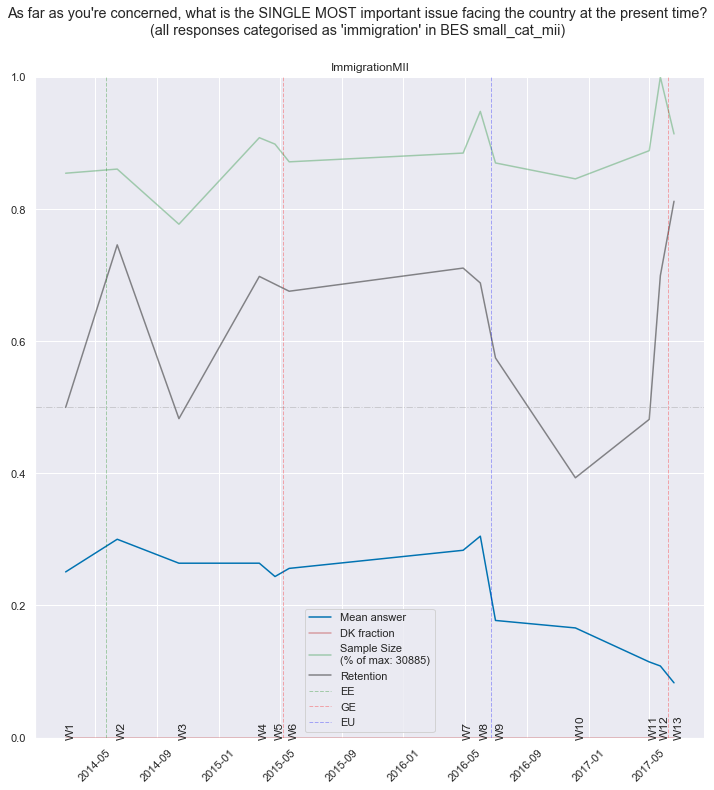

In [138]:
%%time
var_name = ""
title= "\n".join(["As far as you're concerned, what is the SINGLE MOST important issue facing the country at the present time?",
                  "(all responses categorised as 'immigration' in BES small_cat_mii)"])
specific_suffix_set = "(ImmigrationMII)"
col_wrap = 1
height   = 10

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

# Immigration Expectation variables

Wall time: 3min 9s


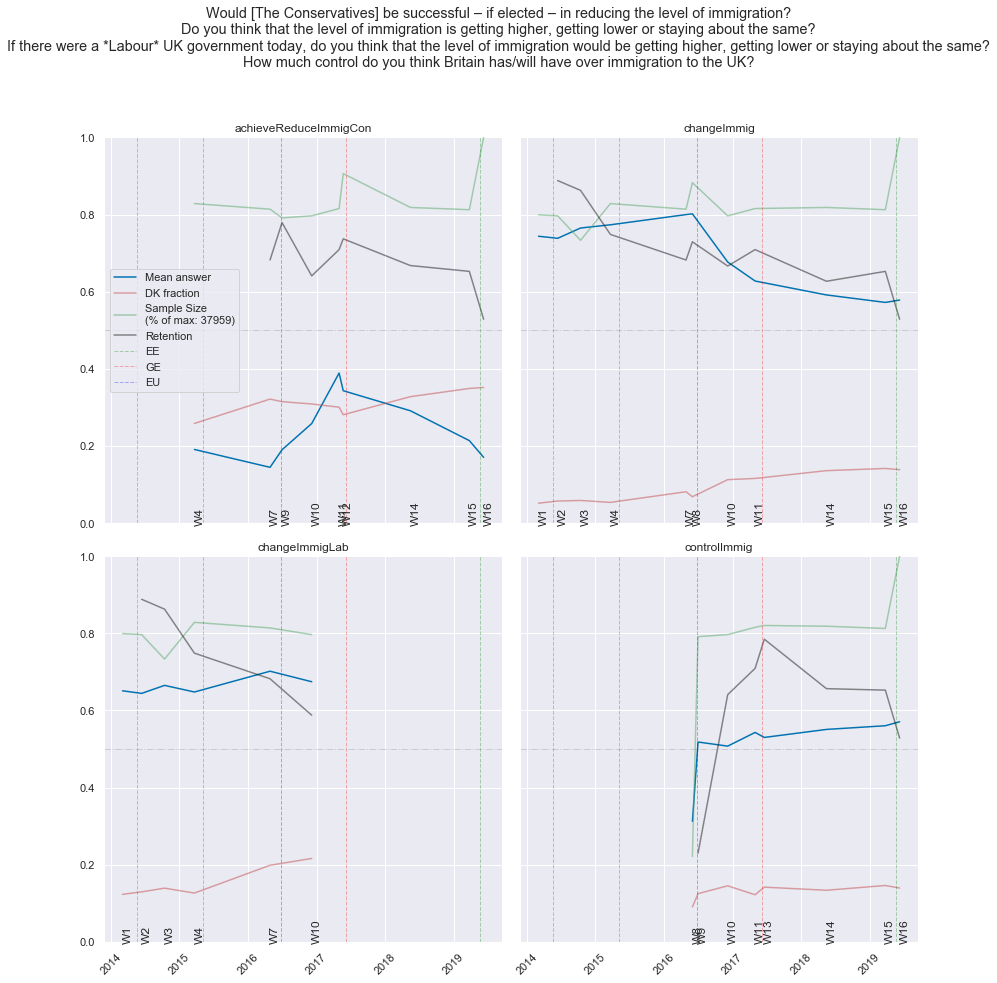

In [140]:
%%time
var_name = ""
title= "\n".join(["Would [The Conservatives] be successful – if elected – in reducing the level of immigration?",
                  "Do you think that the level of immigration is getting higher, getting lower or staying about the same?",
                  "If there were a *Labour* UK government today, do you think that the level of immigration would be getting higher, getting lower or staying about the same?",
                  "How much control do you think Britain has/will have over immigration to the UK?"])
specific_suffix_set = "(changeImmig|controlImmig|changeImmigLab|achieveReduceImmigCon)"
col_wrap = 2
height   = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

# quick check of NINO data

In [114]:
nino = pd.read_stata( BES_data_folder+os.sep+"Portes"+os.sep+"NINO Constituencies - Annual.dta" )
nino

,id,year,constituency,EU_reg,other_europe,asia,rest_world,other,total,postref,nonEU_reg,tot,yearnum,con,EUpostref,EUprefre,dEU_reg,dnonEU_reg,dEUpostref
0,Aberavon2011-2012,2011-2012,Aberavon,37,0,42,7,0,95,0,49.0,86.0,2011-2012,Aberavon,0.0,-37.0,NaN,NaN,NaN
1,Aberavon2012-2013,2012-2013,Aberavon,32,0,34,0,0,79,0,34.0,66.0,2012-2013,Aberavon,0.0,-32.0,-5.0,-15.0,0.0
2,Aberavon2013-2014,2013-2014,Aberavon,40,0,24,0,0,69,0,24.0,64.0,2013-2014,Aberavon,0.0,-40.0,8.0,-10.0,0.0
3,Aberavon2014-2015,2014-2015,Aberavon,51,0,33,11,0,108,0,44.0,95.0,2014-2015,Aberavon,0.0,-51.0,11.0,20.0,0.0
4,Aberavon2015-2016,2015-2016,Aberavon,73,0,30,7,0,118,0,37.0,110.0,2015-2016,Aberavon,0.0,-73.0,22.0,-7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,York Outer2013-2014,2013-2014,York Outer,176,5,134,45,0,370,0,184.0,360.0,2013-2014,York Outer,0.0,-176.0,18.0,-24.0,0.0
4420,York Outer2014-2015,2014-2015,York Outer,275,28,175,64,0,540,0,267.0,542.0,2014-2015,York Outer,0.0,-275.0,99.0,83.0,0.0
4421,York Outer2015-2016,2015-2016,York Outer,198,6,160,47,0,416,0,213.0,411.0,2015-2016,York Outer,0.0,-198.0,-77.0,-54.0,0.0
4422,York Outer2016-2017,2016-2017,York Outer,217,5,107,49,0,388,1,161.0,378.0,2016-2017,York Outer,217.0,0.0,19.0,-52.0,19.0


* year -> when in the year? Is there a specific accounting year end point?
* EU_reg|other_europe|asia|rest_world|other
* adds up to same as "tot"

* what is "other" that it isn't caught in "rest_world"?


* but not "total" - what is "total" and why doesn't it agree with the sum of EU_reg|other_europe|asia|rest_world|other
* total-sum = 4791597 - discrepancy of 9121?? matches no other column 

* nonEU_reg == sum(other_europe|asia|rest_world|other)
* postref -> ah - binary flag for before/after ref

* EUpostref -> looks like EU_reg x postref
* EUprefre -> looks like -EU_reg x (1-postref)

* dEU_reg -> change in EU_reg (from last year in same constituency)
* dnonEU_reg -> change in nonEU_reg (from last year in same constituency)
* dEUpostref -> dEU_reg x postref

# choice of which pairs of waves to try to focus an initial "drivers of change" analysis on


Impact of Euref Campaign Pair 7->8
Impact of Euref Result Pair 8->10



Best wave choice

immigEcon/Cult 7/8/10/11
    - 7->8->10 sharp, 10->11 weaker

changeImmig 7/8/10/11
    - no clear shift 7->8
    - 8->10 sharp, 8->11 okay
    
immigrantsWelfareState 7/8/10/11
    - sharp increase 7->8->10
    - weaker 10->11
    
ukCoopMovement 7/8/10
    - sharp increase 7->8->10
    
effectsEUImmigration 7/8/10/11
    - falls 7->8 ???
    - 8->10 increase
    - 10->11 flat

immigContributeTake 7/8
    - big shift 7->8    
    
immigSelf 7/8/9/10/11
    -(has partials in 12/13)
    - appears to dip 7->8, sharpest rise 8->9

controlImmig 8/9/10/11/13
    - tragically, wave 8 is only a partial sample - but super sharp transition
    - 9-> 10 actually falls, 9->11/10->11 small/large increase
    - falls again 11->13    
    
(eu|noneu|families|asylum|students)More 7/8/13
    - consistent increase 8->13
    - 7-8 sharper but less consistent (flat for eu, bump for noneu, neg for families)
    
achieveReduceImmigCon 7/9/10/11/12
    - 4->7 is a fall
    - 7->9-10->11 increase
    - 11->12 sharp fall, 12-> continuous fall

# Media variables

* all these variables reflect the "profile_newspaper_readership_201" yougov variable
* note that this is "Which daily newspaper do you read most often?"
* you could legitimately read the Express and Mail about as often and oscillate between
* also there's a huge editorial (and anecdotally I understand readership) difference between
* Mail on Sunday (Remain! - contains weekly TV listings) and the Daily Mail (Leave!)

* "profiles_newspaper2W16" is obviously just a "top up" sample
* "profile_newspaper" is an amalgamation of all the waves

* Full Waves 10, 11, 12, 13, 15

In [145]:
search(BES_Panel,"newspaper")

newspaperReadW15          30842
profile_newspaperW10      30237
profile_newspaperW11      30956
profile_newspaper2W12     34394
profile_newspaperW13      31136
profiles_newspaper2W16    13775
profile_newspaper         56590
dtype: int64

* they're a bit None heavy (and region matters)

In [12]:
BES_Panel["profile_newspaper"].value_counts()


None                                           17336
The Sun                                         7390
The Daily Mail / The Scottish Daily Mail        7333
The Mirror / Daily Record                       4400
The Guardian                                    4395
Other Newspaper                                 3720
The Daily Telegraph                             2703
The Times                                       2696
Other local daily morning newspaper             2240
The Independent                                 1318
The Express                                     1061
The Herald (Glasgow)                             559
The Daily Star / The Daily Star of Scotland      536
The Scotsman                                     388
The Financial Times                              313
The Western Mail                                 202
Name: profile_newspaper, dtype: int64

# BES Media module variables

* infoSource

* search(BES_Panel,"infoSource")

* During the last seven days, on average how much time (if any) have you spent per day following news about
* politics or current affairs from each of these sources?

* TV/Paper/Radio/Internet/People
* Full waves 4, 5, 6, 7, 8, 12, 13, 15

In [148]:
BES_Panel["infoSourceTVW4"].value_counts()

Less than 1/2 hour      8832
1/2 hour to 1 hour      8560
1 to 2 hours            5313
None, no time at all    4180
More than 2 hours       3497
Don't know              1063
Name: infoSourceTVW4, dtype: int64

* twitterUse: Full Waves 4, 5, 6, 12
* Do you use Twitter? Yes/No/DK (mostly No!, ~8000/30+k = Yes)

* ~8000 people that say Yes then asked
* twitterInfo(_1/2/3) Partial Sample Waves 4, 5, 12
* In the last 4 weeks, have you read news or found information about the upcoming general election or politics
* more generally that was tweeted by any of the following people or organisations? Tick all that apply
* twitterInfo_1: Candidates or parties on Twitter
* twitterInfo_2: Someone you know personally on Twitter
* twitterInfo_3: Other people on Twitter e.g. commentators, journalists, activists

* Yes/No/DK/Don't follow politics on twitter (mostly Don't follow politics on twitter)



* twitterInfof2f Partial Sample Wave 6
* During the election campaign, did you get news about politics and the election through twitter?
* Yes/No/DK

In [149]:
BES_Panel["twitterInfof2fW6"].value_counts()

Yes           4462
No            3806
Don't know     113
Name: twitterInfof2fW6, dtype: int64

* fbUse: Full Waves 4, 5, 6, 12
* Do you use Facebook? Yes/No/DK (mostly No!, ~20k/30+k = Yes)

* ~20000 people that say Yes then asked
* fbInfo(_1/2/3) Partial Sample Waves 4, 5, 12
* In the last 4 weeks, have you read news or found information about the upcoming general election or politics more
* generally that was posted on Facebook by any of the following people or organisations? Tick all that apply
* fbInfo_1 Candidates or parties on Facebook
* fbInfo_2 Someone you know personally on Facebook
* fbInfo_3 Other people on Facebook e.g. commentators, journalists, activists
* Yes/No/DK/Don't follow politics on facebook (mostly Don't follow politics on facebook - even moreso than twitter)


* fbInfof2fW6 Partial Sample Wave 6
* During the election campaign, did you get news about politics and the election through Facebook?
* Yes/No/DK

In [151]:
BES_Panel["fbInfo_1W4"].value_counts()

Don't follow politics on facebook    14308
No                                    3028
Yes                                   2589
Don't know                             994
Name: fbInfo_1W4, dtype: int64

* euSources Full Waves 7, 8
* Have you heard anything about the EU referendum from any of these during the last seven days?
* Please tick all that apply.
* euSources_1: Television
* euSources_2: Newspaper (including online)
* euSources_3: Radio
* euSources_4: Internet (not including online newspapers)
* euSources_5: Talking to other people

* Yes/No/DK

# need to download/open up the open-ended question dataset for
* tvWatch/radioList/paperRead/internetRead

* urk - ugly human data

* What are the most important Internet sources (including online newspapers) you read
* for information about politics and the election?
* List up to three websites or click next if there are no websites you can think of.

* TV/radio/newspaper/internet

* whole bunch of variables about visiting a party site/sharing party website/fb/twitter stuff -> ignoring

# geo variables

In [52]:
match(BES_Panel,"pano")
# every wave except 1

panoW11    48508
panoW12    34393
panoW13    30985
panoW14    32578
panoW2     30467
panoW3     27837
panoW6     28583
panoW1     30382
panoW5     31039
panoW7     32248
panoW8     33504
panoW9     30172
panoW10    32748
panoW15    31006
panoW16    39431
dtype: int64

In [53]:
match(BES_Panel,"gor")
# less regular update for regions

gorW11    30956
gorW12    34394
gorW14    31063
gorW15    30842
gorW16    37959
gorW13    30985
gorW2     30467
gorW3     27837
gorW6     28583
gor       66696
dtype: int64

In [54]:
match(BES_Panel,"profile_lea")
# more coarse than constituency!

profile_lea    60173
dtype: int64

In [55]:
BES_Panel["profile_lea"]

0        Cheshire West and Chester
1                           Surrey
2                     Lincolnshire
3                      Southampton
4                    Herefordshire
                   ...            
92582                          NaN
92583                          NaN
92584                          NaN
92585                          NaN
92586                          NaN
Name: profile_lea, Length: 92587, dtype: category
Categories (206, object): [Aberdeen City, Aberdeenshire, Angus, Argyll & Bute, ..., Wolverhampton, Worcestershire, Wrexham, York]